# Improving Discriminant Analysis

Now, we investigate ways to improve our discriminant analysis models, including cross-validation and Regularised Discriminant Analyis, the latter of which was discussed previously.
First, we import and pre-process the data into this noteobook. (this code is repeated from before)

## Importing Libraries
We need NumPy, Pandas, Seaborn, Matplotlib and various functions from different sub-libraries of the scikit-learn library.

Discriminant analysis can only handle numeric inputs, so we must one-hot encode the categorical features in our dataset, using OneHotEncoder from scikit-learn.

Also, since LDA and QDA assume that features are normally distributed within each class, we standardise the data using StandardScaler from scikit-learn.

We also import the metric functions accuracy_score, confusion_matrix and classification_report which contains all of the relevant metrics (precision, recall, f1-score, support, accuracy) from scikit-learn so that we can evaluate the performance of our classification models. Although classifiiction_score contains the accuracy, we import the accuracy_score function for convenience.

Finally, we note that we need to import roc_curve and auc from scikit-learn so that we may compare the performance of our models using receiver-operator curves.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Training and Test Data

In [2]:
# Load the saved datasets from the CSV files
X_train = pd.read_csv("../data/X_train.csv", index_col=0)  # Use the first column as index
y_train = pd.read_csv("../data/y_train.csv", index_col=0)  # Use the first column as index
X_test = pd.read_csv("../data/X_test.csv", index_col=0)    # Use the first column as index
y_test = pd.read_csv("../data/y_test.csv", index_col=0)    # Use the first column as index

# Display the first few rows of the loaded datasets
(X_train.head(), y_train.head(), X_test.head(), y_test.head())

(   age         workclass  fnlwgt  education  education-num  \
 0   39         State-gov   77516  Bachelors             13   
 1   50  Self-emp-not-inc   83311  Bachelors             13   
 2   38           Private  215646    HS-grad              9   
 3   53           Private  234721       11th              7   
 4   28           Private  338409  Bachelors             13   
 
        marital-status         occupation   relationship   race     sex  \
 0       Never-married       Adm-clerical  Not-in-family  White    Male   
 1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
 2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
 3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
 4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   
 
    capital-gain  capital-loss  hours-per-week native-country  
 0          2174             0              40  United-States  
 1             0             0          

## Pre-processing Data
Now, we one-hot encode the categorical columns so that all of the columns are numeric for our models. Next, we convert our data to a dataframe since this is easier to work with. We finish by standardising the data and ensuring the data is in the correct form for our modelling.

In [3]:
# Separate the numeric and categorical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# One-hot encode the categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')

X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Convert the encoded categorical variables into DataFrames
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the numeric columns back with the one-hot encoded categorical columns
X_train_full = pd.concat([X_train[numeric_columns].reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_test[numeric_columns].reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

# Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Ensure the target variables are flattened arrays
y_train_array = y_train['income'].values.ravel()
y_test_array = y_test['income'].values.ravel()

## Regularised Discriminant Analysis
We now implement RDA, by fitting the model, then testing our model on the test data. We evaluate the performance of our model using accuracy, the confusion matrix, precision, recall and F1-score.

We do so by creating a RegularisedDiscriminantAnalysis class since there is no regularised discriminant analysis class in scikit-learn. We will use this class in the same way as our other models but will omit extra functions which we will not use in our modelling.

We use the scikit-learn GitHub file: 'https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/discriminant_analysis.py' and the GitHub file: 'https://github.com/jihoonerd/restricted-discriminant-analysis/blob/main/rda/rda_model.py', using the LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis and RDA class code to help us define our RegularisedDiscriminantAnalysis class.

We will use the RDA() class defined using the BaseEstimator as in the 'rda_model.py' file.

The code from the 'rda_model.py' file allows us to initialise variables, fit and predict with our model. We need to set $\alpha=0$ and the variance variable equal to 0 since we will not use the nearest mean classifier as we have not previously discussed this. The $\beta$ parameter controls the balance between LDA and QDA for our regularised discriminant analysis. We will use $\beta=0.5$ to have equal balance of the LDA and QDA but note that this could be optimised.

In [4]:
# This code has been taken from GitHub (as described above) and edited for specific use in this document
from sklearn.base import BaseEstimator

class RDA(BaseEstimator):
    """
    Restricted Discriminant Analysis (RDA) Estimator class.
    This inherits `BaseEstimator` class from `scikit-learn` to seamlessly integrate with other preprocessing module of it.
    RDA can model as LDA, QDA, nearest mean classifier, or mixture of them depending on hyperparameters, alpha, beta, and variance.
    """
    def __init__(self, alpha=0.0, beta=0.0, variance=0):
        """
        alpha, beta, and varaince decide the characteristics of RDA.
        Followings are remarks of RDA upon settings of hyperparameters:
        alpha = beta = 0:  QDA
        alpha=0, beta=1: LDA
        alpha=1, beta=0: nearest mean classifier
        """

        self.fitted = False
        self.alpha = alpha
        self.beta = beta
        self.variance = variance
        self.class_labels = []
        self.priors = {}
        self.means = {}
        self.rda_cov = {}
        
    def fit(self, X, y):
        self.class_labels = np.unique(y)
        S_i = {}
        pooled_covariance = 0

        for i in self.class_labels:
            indices = np.where(y == i)[0]
            samples = X[indices, :]
            self.priors[i] = float(len(indices)) / len(y) # class ratio (prior)
            self.means[i] = np.mean(samples, axis=0) # mean vector of each features (N,NUM_FEATURES)
            S_i[i] = np.cov(samples, rowvar=0)
            pooled_covariance += S_i[i] * self.priors[i] # equation (3) above.

        # Calculate RDA regularized covariance matricies for each class
        for i in self.class_labels:
            self.rda_cov[i] = self.alpha * self.variance * np.eye(X.shape[1]) + self.beta * pooled_covariance + (1 - self.alpha - self.beta) * S_i[i]
        self.fitted = True

    def predict(self, X):

        if not self.fitted:
            raise NameError('Fit model first')

        predictions = []

        for i in range(len(X)):
            x = X[i]
            discriminant_score = {}
            for i in self.class_labels:
                part1 = -0.5 * np.linalg.det(self.rda_cov[i])
                part2 = -0.5 * (x - self.means[i]).T @ np.linalg.pinv(self.rda_cov[i]) @ (x - self.means[i])
                part3 = np.log(self.priors[i])
                discriminant_score[i] = part1 + part2 + part3 # 5.19 in textbook
            prediction = max(discriminant_score, key=discriminant_score.get)
            predictions.append(prediction)
        return predictions

In [5]:
# Fit the Regularised Discriminant Analysis (RDA) model (may take longer than previous models)
# We are using the above RDA class to do this with beta=0.5
rda = RDA(beta=0.5)
rda.fit(X_train_scaled, y_train_array)

# Predict on the test set
y_pred_rda = rda.predict(X_test_scaled)

# Evaluate the model's performance
rda_accuracy = accuracy_score(y_test_array, y_pred_rda)
rda_conf_matrix = confusion_matrix(y_test_array, y_pred_rda)

# Print the evaluation results
print(f'Accuracy: {rda_accuracy:.2f}')
print('Confusion Matrix:')
print(rda_conf_matrix)

# Generate the classification report as a dictionary for later use
rda_report = classification_report(y_test_array, y_pred_rda, target_names=['<=50K', '>50K'], output_dict=True)

# Print classification report in a readable table
rda_report_table = classification_report(y_test_array, y_pred_rda, target_names=['<=50K', '>50K'], output_dict=False)
print(rda_report_table)

Accuracy: 0.80
Confusion Matrix:
[[5640 1222]
 [ 606 1600]]
              precision    recall  f1-score   support

       <=50K       0.90      0.82      0.86      6862
        >50K       0.57      0.73      0.64      2206

    accuracy                           0.80      9068
   macro avg       0.73      0.77      0.75      9068
weighted avg       0.82      0.80      0.81      9068



The accuracy of 80% is much better than the QDA model but slightly worse than the LDA model from before, suggesting an improvement which could be increased by optimising the choice of the $\beta$ value.

We will provide visualisations of this classification report and the confusion matrix below.

## Visualisations and Metrics for RDA

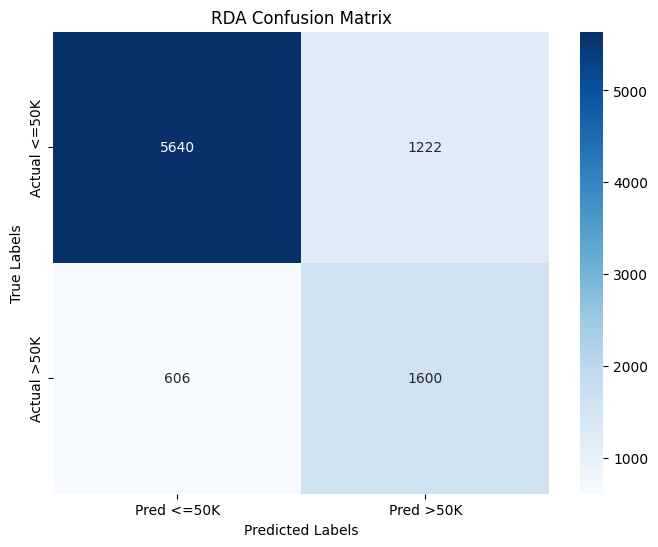

In [6]:
# Plotting the confusion matrix   
# Add figure
plt.figure(figsize=(8,6))

# RDA confusion matrix
sns.heatmap(rda_conf_matrix, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Pred <=50K', 'Pred >50K'], 
               yticklabels=['Actual <=50K', 'Actual >50K'])
plt.title('RDA Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

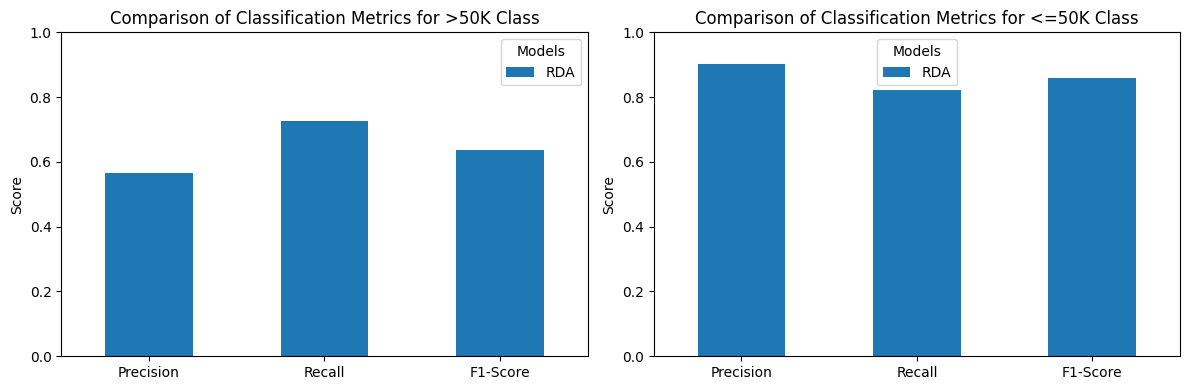

In [7]:
# Create DataFrames for the >50K and <=50K classification reports
comparison_df_high = pd.DataFrame({
    'RDA': [rda_report['>50K']['precision'], rda_report['>50K']['recall'], rda_report['>50K']['f1-score']]
}, index=['Precision', 'Recall', 'F1-Score'])

comparison_df_low = pd.DataFrame({
    'RDA': [rda_report['<=50K']['precision'], rda_report['<=50K']['recall'], rda_report['<=50K']['f1-score']]
}, index=['Precision', 'Recall', 'F1-Score'])

# Add figure
plt.figure(figsize=(12, 4))

# Plot for >50K class
plt.subplot(1, 2, 1)
comparison_df_high.plot(kind='bar', ax=plt.gca())
plt.title('Comparison of Classification Metrics for >50K Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')

# Plot for <=50K class
plt.subplot(1, 2, 2)
comparison_df_low.plot(kind='bar', ax=plt.gca())
plt.title('Comparison of Classification Metrics for <=50K Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')

# Show plots
plt.tight_layout()
plt.show()

The Regularised Discriminant Analysis model has an accuracy of 80% - correctly classified 80% of datapoints - which is very good. We take the 'positive' class to be '>50K' and the 'negative' class to be '<=50K'.

We see that there were 5640 true negatives and 1600 true positives, compared to 1222 false negatives and 606 false positives. 
The high number of true negatives compared to true positives indicates that the model performs better in predicting the lower income '<=50K' class. There is also a farily high number of false negatives which suggests that the model's ability to identify higher income '>50K' people.

The precisions shows that the model correctly classifies someone's income as '<=50K' with 90% probability and as '>50K' with 57% probability. This difference in probability shows that the model is much less reliable when it predicts someone to have higher income.

A recall of 82% for the '<=50K' class implies that the model is very good at classifiying '<=50K' incomes. The lower recall of 73% for the higher income class shows that the model still fails to identify a large number of high income people.

The F1-score gives the tradeoff between precision and recall. The '<=50K' class has a high score of 86% showing a strong balance between the precision and recall, whereas  the '>50K' class score of 64% shows that the model needs to be improved so that it has as much success in classifying the higher income people as with the lower income people.

Overall, the results show that the model had good accuracy, however, there is still a clear imbalance with the metrics due to the lower predictive ability of the model classifying the higher income class.

## RDA Conclusion
The implementation of Regularised Discriminant Analysis seems to be a suitable choice to classify our income data. The accuracy of 80% is much better than the QDA model but slightly worse than the LDA model from before, but since we chose the $\beta$ value without any optimisation techniques, it is likely that there is room for further improvement if we did so.

## Cross-validation for Discriminant Models
We will now implement cross-validation for our LDA, QDA and RDA models to reduce overfitting and hopefully improve our models' accuracies and other related metrics.
We will use the cross_val_score function from scikit-learn with 5 folds.

In [13]:
from sklearn.model_selection import cross_val_score

### Cross-validation for LDA

In [19]:
# Perform cross-validation (simple 5-fold cross-validation) for LDA
lda = LinearDiscriminantAnalysis()

# Use 5-fold cross-validation and calculate the accuracy for each fold
lda_cv_scores = cross_val_score(lda, X_train_scaled, y_train_array, cv=5, scoring='accuracy')

# Print cross-validation results
print(f'Cross-Validation Accuracy Scores: {lda_cv_scores}')
print(f'Mean CV Accuracy: {lda_cv_scores.mean():.2f}')
print(f'Standard Deviation of CV Accuracy: {lda_cv_scores.std():.2f}')

Cross-Validation Accuracy Scores: [0.83947203 0.83959774 0.84186047 0.84475173 0.84259492]
Mean CV Accuracy: 0.84
Standard Deviation of CV Accuracy: 0.00


### Cross-validation for QDA

In [20]:
# Perform cross-validation (simple 5-fold cross-validation) for QDA
qda = QuadraticDiscriminantAnalysis()

# Use 5-fold cross-validation and calculate the accuracy for each fold
qda_cv_scores = cross_val_score(qda, X_train_scaled, y_train_array, cv=5, scoring='accuracy')

# Print cross-validation results
print(f'CV Accuracy Scores: {qda_cv_scores}')
print(f'Mean CV Accuracy: {qda_cv_scores.mean():.2f}')
print(f'Standard Deviation of CV Accuracy: {qda_cv_scores.std():.2f}')

C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Cross-Validation Accuracy Scores: [0.51653048 0.45468259 0.48372093 0.4477687  0.46567765]
Mean CV Accuracy: 0.47
Standard Deviation of CV Accuracy: 0.02


C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


We can see that warning messages about the collinearity of some of the variables are showing still and this must be addressed in order to improve the QDA model.

### Cross-validation for RDA
We experimented with cross-validation for the RDA model but this had a significantly long runtime so we omit this from the project.

## Cross-validation Conclusion
Using 5-fold cross validation improved the accuracy of the QDA model but not enough to make the model successful. The LDA accuracy was unaffected by the cross-validation.

## Addressing Collinearity in QDA
When we implement our QDA model we encounter warning messages stating 'Variables are collinear'. We will finish this part of the project by investigating ways to remedy this.

## Removing Highly-Correlated Variables
We look for highly-correlated variables which are affecting the QDA and will remove any found to hopefully improve our model.

In [38]:
# Calculate correlation matrix
corr_matrix = X_train_encoded.corr()

# Identify columns with high correlation (> 0.9)
high_corr_pairs = []

# Iterate through the correlation matrix to find highly correlated pairs
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print(f"Highly-correlated pairs: {high_corr_pairs}")

Highly-correlated pairs: [('occupation_nan', 'workclass_nan')]


We have found that 'occupation' and 'workclass' are highly correlated. From our EDA we know that these variables have large amounts of missingness which is likely contributing to why they are correlated so highly. Also, missingess is an issue when we are modelling our data, so here we will remove these variables when we pre-process our data and re-run our QDA model using cross-validation.

In [47]:
# Drop the highly correlated variables from the dataset
X_train_reduced = X_train_encoded.drop(columns=(['workclass_nan', 'occupation_nan']))
X_test_reduced = X_test_encoded.drop(columns=(['workclass_nan', 'occupation_nan']))

# Concatenate the numeric columns back with the one-hot encoded categorical columns
X_train_full = pd.concat([X_train[numeric_columns].reset_index(drop=True), X_train_reduced.reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_test[numeric_columns].reset_index(drop=True), X_test_reduced.reset_index(drop=True)], axis=1)

# Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Ensure the target variables are flattened arrays
y_train_array = y_train['income'].values.ravel()
y_test_array = y_test['income'].values.ravel()

In [48]:
# Perform cross-validation (simple 5-fold cross-validation) for QDA
qda = QuadraticDiscriminantAnalysis()

# Use 5-fold cross-validation and calculate the accuracy for each fold
qda_cv_scores = cross_val_score(qda, X_train_scaled, y_train_array, cv=5, scoring='accuracy')

# Print cross-validation results
print(f'Cross-Validation Accuracy Scores: {qda_cv_scores}')
print(f'Mean CV Accuracy: {qda_cv_scores.mean():.2f}')
print(f'Standard Deviation of CV Accuracy: {qda_cv_scores.std():.2f}')

C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Cross-Validation Accuracy Scores: [0.62928975 0.46775613 0.39409177 0.58843495 0.59127483]
Mean CV Accuracy: 0.53
Standard Deviation of CV Accuracy: 0.09


C:\Users\milse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


We still have warning messages, however, removing these variables improved the mean cross-validation accuracy score for the QDA model. We must be cautious of the fact that the standard deviation of the accuracy increased by about 7%.

## Conclusion
We have investigated three types of discriminant analysis models. The linear discriminant analysis model and the regularised dsicriminant analysis model significantly outperformed the quadratic discriminant analysis model. We used cross-validation to slightly improve our models and we identified that the missingness of certain features impacted our overall model performance. We end this section with some confidence in discriminant analysis models to classify income data, taking care to improve our models to prevent bias towards the lower income class. This was expected due to the imbalance in our dataset but still needs to be remedied.

## References
[1] Hastie, Trevor, et al. The elements of statistical learning: data mining, inference, and prediction. Vol. 2. New York: springer, 2009.

[2] Research Method Article: https://researchmethod.net/discriminant-analysis/

[3] scikit-learn Documentation - 1.2 Linear and Quadratic Discriminant Analysis: https://scikit-learn.org/stable/modules/lda_qda.html

[4] scikit-learn Documenation - 6.3 Preprocessing data: https://scikit-learn.org/stable/modules/preprocessing.html

[5] sckit-learn Documentation - 3.4 Metrics and scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#

[5] Sebastian Raschka’s PCA vs LDA article with Python Examples: https://sebastianraschka.com/Articles/2014_python_lda.html#lda-via-scikit-learn

[6] Data Science Toolbox Lecture Notes on ROC Curves: https://dsbristol.github.io/dst/assets/slides/05.1-Classification.pdf

[7] scikit-learn GitHub RDA Implementation: https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/discriminant_analysis.py

[8] scikit-learn cross_val_score Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html